In [13]:
#you need to add a dataset with GaussJacobiQuadRule_V3 on the right 
import sys
#sys.path.insert(1, '/kaggle/input/quadrule')
from GaussJacobiQuadRule_V3 import Jacobi, DJacobi, GaussLobattoJacobiWeights, GaussJacobiWeights

#import GaussJacobiQuadRule_V3

In [14]:
# %load building_VPINN_network.py


###############################################################################

# import tensorflow as tf

import tensorflow 
tf=tensorflow.compat.v1
#tf.disable_v2_behavior()
import pyDOE

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pyDOE import lhs
#from GaussJacobiQuadRule_V3.py import Jacobi, DJacobi, GaussLobattoJacobiWeights, GaussJacobiWeights
import time

#from tensorflow import placeholder


np.random.seed(1234)
tf.compat.v1.set_random_seed(1234)

###############################################################################

                  #X_u_train,u_train,               points for training at the boundary 
                  #X_quad_train, W_quad_train,      quadrature weights and points in [-1,1](N_quad is their number) arrays
                  #F_ext_total,                     fh calculated on each elem for each test function on the real nodes array 
                  #grid,                            lispace grid between -1 and 1 with N_quad number of points points 
                  #X_test,u_test     		    test points between -1 and 1 depends on delta_test and uex evalueted on these
                  #Net_layer         		    array of integer with number of neurons for each layer
                  #X_f_train,                       Nf points for trianing,then evalueted on f
                  #f_train,                         
                  #params=params                    hyperparameters of the network/loss options 

class VPINN:
    def __init__(self, X_u_train, u_train, X_quad, W_quad, F_exact_total,\
                 grid, X_test, u_test, layers, X_f_train, f_train, params):

        self.x       = X_u_train
        self.u       = u_train
        
        self.xf      = X_f_train
        self.f      = f_train
        
        self.xquad   = X_quad
        self.wquad   = W_quad  #weights for quadrature to calculate the loss
        
        self.xtest   = X_test
        self.utest   = u_test
        
        self.F_ext_total = F_exact_total
        self.Nelement = np.shape(self.F_ext_total)[0]  #number of elements  
        self.N_test   = np.shape(self.F_ext_total[0])[0] #number of test function
        



        self.x_tf   = tf.placeholder(tf.float64, shape=[None, self.x.shape[1]]) #????placeholder is a variable that we will assign later on
        self.u_tf   = tf.placeholder(tf.float64, shape=[None, self.u.shape[1]])
        self.xf_tf   = tf.placeholder(tf.float64, shape=[None, self.xf.shape[1]])
        self.f_tf   = tf.placeholder(tf.float64, shape=[None, self.f.shape[1]])
        self.x_test = tf.placeholder(tf.float64, shape=[None, self.xtest.shape[1]])
        self.x_quad = tf.placeholder(tf.float64, shape=[None, self.xquad.shape[1]])
      
        self.weights, self.biases, self.a = self.initialize_NN(layers)
        
        #ingredients for discrete integrals,remark the newtork is not just one you need to calculate in poisson case u(x,y) ,d/dx u(x,y) ,d/dy u(x,y)
        
        self.u_NN_quad  = self.net_u(self.x_quad) #x_quad is a row tensor 
        
        self.d1u_NN_quad, self.d2u_NN_quad = self.net_du(self.x_quad)
         
       	self.test_quad=self.Test_fcn(self.N_test, self.xquad)
       	
        self.d1test_quad, self.d2test_quad = self.dTest_fcn(self.N_test, self.xquad)
        
 
        
        self.u_NN_pred   = self.net_u(self.x_tf)
        self.u_NN_test   = self.net_u(self.x_test)
        self.f_pred = self.net_f(self.x_test) #evaluete f through the network ??
        
        
        #start from there -> loss calculation
        self.varloss_total = 0
        for e in range(self.Nelement):
            F_ext_element  = self.F_ext_total[e]
            Ntest_element  = np.shape(F_ext_element)[0] #for each element of the grid you have a vector of the focing term (suppose its n-loc),so the you can have at most quad formula n_loc
            
            x_quad_element = tf.constant(grid[e] + (grid[e+1]-grid[e])/2*(self.xquad+1))
            x_b_element    = tf.constant(np.array([[grid[e]], [grid[e+1]]]))
            #to change change integral to the ref segment in (-1,1)
            jacobian       = (grid[e+1]-grid[e])/2

            test_quad_element = self.Test_fcn(Ntest_element, self.xquad)
            d1test_quad_element, d2test_quad_element = self.dTest_fcn(Ntest_element, self.xquad)
            u_NN_quad_element = self.net_u(x_quad_element)
            d1u_NN_quad_element, d2u_NN_quad_element = self.net_du(x_quad_element)

            u_NN_bound_element = self.net_u(x_b_element)
            d1test_bound_element, d2test_bounda_element = self.dTest_fcn(Ntest_element, np.array([[-1],[1]]))

            var_form = params['var_form']

            if var_form == 1:
                U_NN_element = tf.reshape(tf.stack([-jacobian*tf.reduce_sum(self.wquad*d2u_NN_quad_element*test_quad_element[i]) \
                                                   for i in range(Ntest_element)]),(-1,1))
            if var_form == 2:
                U_NN_element = tf.reshape(tf.stack([ tf.reduce_sum(self.wquad*d1u_NN_quad_element*d1test_quad_element[i]) \
                                                    for i in range(Ntest_element)]),(-1,1))                                 #i think we are going to use this most of the times 
            if var_form == 3:
                U_NN_element = tf.reshape(tf.stack([-1/jacobian*tf.reduce_sum(self.wquad*u_NN_quad_element*d2test_quad_element[i]) \
                                                   +1/jacobian*tf.reduce_sum(u_NN_bound_element*np.array([-d1test_bound_element[i][0], d1test_bound_element[i][-1]]))  \
                                                   for i in range(Ntest_element)]),(-1,1))
                

            Res_NN_element = U_NN_element - F_ext_element
            loss_element = tf.reduce_mean(tf.square(Res_NN_element))
            self.varloss_total = self.varloss_total + loss_element
        
        self.lossb = tf.reduce_mean(tf.square(self.u_tf - self.u_NN_pred))  #u_NN_pred is what your network has calc,while u_tf is the real value
        self.lossv = self.varloss_total
        #two losses 
        self.loss  = params['lossb_weight']*self.lossb + self.lossv
        
        self.LR = params['LR']
        self.optimizer_Adam = tf.train.AdamOptimizer(self.LR)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        self.sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))
        self.init = tf.global_variables_initializer()
        self.sess.run(self.init)

###############################################################################
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        #transpose everything to have the classic form y=W*x+b 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float64), dtype=tf.float64)
            a = tf.Variable(0.01, dtype=tf.float64)
            weights.append(W)
            biases.append(b)        
        return weights, biases, a
        
        
    def xavier_init(self, size): #marked for future develop*********************
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim), dtype=np.float64)
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev,dtype=tf.float64), dtype=tf.float64) #maybe should the init be changed
 
    def neural_net(self, X, weights, biases, a): #marked for future develop 
        num_layers = len(weights) + 1
        H = X 
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.sin(tf.add(tf.matmul(H, W), b)) #change here for having different activation function
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_u(self, x):  #marked for future develop
        u = self.neural_net(tf.concat([x],1), self.weights, self.biases, self.a)
        return u

    def net_du(self, x): #calculates first and second derivatives of the input unn d/dx unn d^2/dx^2 unn so it can compute loss
        u   = self.net_u(x)
        d1u = tf.gradients(u, x)[0]
        d2u = tf.gradients(d1u, x)[0]
        return d1u, d2u

    def net_f(self, x): #marked for future develop*********************
        u = self.net_u(x)
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        f = - u_xx
        return f
    
    #vtest functions == jacobi polynomils valueted on a point x
    def Test_fcn(self, N_test,x):
        test_total = []
        for n in range(1,N_test+1):  
            test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
            test_total.append(test)
        return np.asarray(test_total)

    def dTest_fcn(self, N_test,x):  #valuete the first and second derivatives of test functions on a point x 
        d1test_total = []
        d2test_total = []
        for n in range(1,N_test+1):  
            if n==1:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)
            elif n==2:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x) - ((n)/2)*Jacobi(n-2,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)    
            else:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x) - ((n)/2)*Jacobi(n-2,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x) - ((n)*(n+1)/(2*2))*Jacobi(n-3,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)    
        return np.asarray(d1test_total), np.asarray(d2test_total)

    def predict_subdomain(self, grid):
        error_u_total = []
        u_pred_total = []
        for e in range(self.Nelement):
            utest_element = self.utest_total[e]
            x_test_element = grid[e] + (grid[e+1]-grid[e])/2*(self.xtest+1)
            u_pred_element = self.sess.run(self.u_NN_test, {self.x_test: x_test_element})
            error_u_element = np.linalg.norm(utest_element - u_pred_element,2)/np.linalg.norm(utest_element,2)
            error_u_total.append(error_u_element)
            u_pred_total.append(u_pred_element)
        return u_pred_total, error_u_total

    def predict(self, x):
        u_pred  = self.sess.run(self.u_NN_test, {self.x_test: x})
        return u_pred        

    def train(self, nIter, tresh, total_record):
        
        tf_dict = {self.x_tf: self.x, self.u_tf: self.u,\
                   self.x_quad: self.xquad, self.x_test: self.xtest,\
                   self.xf_tf: self.xf, self.f_tf: self.f}    #maybe like variables sess.run will do the rest, u(boundary cond) is assigned to u_tf ,x(boundary) is assigned to x_tf and so on
        start_time       = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            #each 10 iter saves loss values
            if it % 10 == 0:
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_valueb= self.sess.run(self.lossb, tf_dict)
                loss_valuev= self.sess.run(self.lossv, tf_dict)
                total_record.append(np.array([it, loss_value,loss_valueb,loss_valuev]))
                
                if loss_value < tresh:
                    print('It: %d, Loss: %.3e' % (it, loss_value))
                    break
                
            if it % 100 == 0:
                elapsed = time.time() - start_time
                str_print = 'It: %d, Lossb: %.3e, Lossv: %.3e, Time: %.2f'
                print(str_print % (it, loss_valueb, loss_valuev, elapsed))
                start_time = time.time()

        return total_record

In [15]:
tf.compat.v1.disable_v2_behavior()
# from tensorflow import placeholder

                    # a(u,v)=f(v) u in H1 such that is 0 on diriclet boundary for every v in V -->ah(u,vh)=fh(vh) for every vh in Vh

    
    #++++++++++++++++++++++++++++
LR = 0.001
Opt_Niter = 5000 + 1
Opt_tresh = 2e-32
var_form  = 2  #i think that makes the most sense leaving it to 2(variational form)
N_Element = 5
Net_layer = [1] + [20] * 4 + [1] # [1 20 20 20 20 1] number of neurons in each later numer of param == (input_layer+1)*output_layer in this case 2*20+3*(21*20)+21*1=1321 total param
N_testfcn = 20 #number of test function
N_Quad = 100    #quadrature points 
N_F = 500      #number of points used for trianing 
lossb_weight = 1 #hyprparameter we may turn it up

params = {'var_form': var_form, 'lossb_weight': lossb_weight, 'LR': LR}
    
#++++++++++++++++++++++++++++    valuete Test function of order n in a point x(n>=1)
def Test_fcn(n,x):
    test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
    return test

#++++++++++++++++++++++++++++    
#exact sol and forcing term
omega = 8*np.pi
amp = 1
r1 = 80
def u_ext(x):
    utemp = 0.1*np.sin(omega*x) + np.tanh(r1*x)
    return amp*utemp

def f_ext(x):
    gtemp =  -0.1*(omega**2)*np.sin(omega*x) - (2*r1**2)*(np.tanh(r1*x))/((np.cosh(r1*x))**2)
    return -amp*gtemp

#++++++++++++++++++++++++++++ generate once for all quad nodes and weights in the interval [-1,1]
NQ_u = N_Quad
[x_quad, w_quad] = GaussLobattoJacobiWeights(NQ_u, 0, 0)
testfcn = np.asarray([ Test_fcn(n,x_quad)  for n in range(1, N_testfcn+1)])

#generate grid elements,for each element the number of test fuction is the same  
NE = N_Element
[x_l, x_r] = [-1, 1]
delta_x = (x_r - x_l)/NE
grid = np.asarray([ x_l + i*delta_x for i in range(NE+1)])
N_testfcn_total = np.array((len(grid)-1)*[N_testfcn])

if N_Element == 3:
    grid = np.array([-1, -0.1, 0.1, 1])
    NE = len(grid)-1
    N_testfcn_total = np.array([N_testfcn,N_testfcn,N_testfcn])

U_ext_total = []
F_ext_total = []
for e in range(NE):
    x_quad_element = grid[e] + (grid[e+1]-grid[e])/2*(x_quad+1)
    jacobian = (grid[e+1]-grid[e])/2
    N_testfcn_temp = N_testfcn_total[e]
    testfcn_element = np.asarray([ Test_fcn(n,x_quad)  for n in range(1, N_testfcn_temp+1)])
    
    #is this my left side ot the variational form ah calculated in the real nodal values ?  
    u_quad_element = u_ext(x_quad_element)
    U_ext_element  = jacobian*np.asarray([sum(w_quad*u_quad_element*testfcn_element[i]) for i in range(N_testfcn_temp)])
    U_ext_element = U_ext_element[:,None]
    U_ext_total.append(U_ext_element)
    #this is fh calculated on the real nodal values summed over each real nodal values(which comes form CGL nodes )
    f_quad_element = f_ext(x_quad_element)
    F_ext_element  = jacobian*np.asarray([sum(w_quad*f_quad_element*testfcn_element[i]) for i in range(N_testfcn_temp)])
    F_ext_element = F_ext_element[:,None]
    F_ext_total.append(F_ext_element)

# at the end i have an array with my all my "real" residues
U_ext_total = np.asarray(U_ext_total)
F_ext_total = np.asarray(F_ext_total)

#++++++++++++++++++++++++++++
# Training points
X_u_train = np.asarray([-1.0,1.0])[:,None]
u_train   = u_ext(X_u_train)
X_bound = np.asarray([-1.0,1.0])[:,None]

Nf = N_F
X_f_train = (2*lhs(1,Nf)-1) #generate random number of training points 
f_train   = f_ext(X_f_train) #evaluete these points on f(forcing therm)

#++++++++++++++++++++++++++++
# Quadrature points
[x_quad, w_quad] = GaussLobattoJacobiWeights(N_Quad, 0, 0)

X_quad_train = x_quad[:,None] #[[w1],[w2]] none stands for new axis
W_quad_train = w_quad[:,None]

#++++++++++++++++++++++++++++
# Test point
delta_test = 0.001
xtest      = np.arange(-1 , 1 + delta_test , delta_test)  #linspace
data_temp  = np.asarray([ [xtest[i],u_ext(xtest[i])] for i in range(len(xtest))]) # pair input real ouput 
X_test = data_temp.flatten()[0::2]
u_test = data_temp.flatten()[1::2]
#test values 
X_test = X_test[:,None] 
u_test = u_test[:,None] 
f_test = f_ext(X_test)

u_test_total = []
for e in range(NE):
    x_test_element = grid[e] + (grid[e+1]-grid[e])/2*(xtest+1)
    u_test_element = u_ext(x_test_element)
    u_test_element = u_test_element[:,None]
    u_test_total.append(u_test_element)


It: 0, Lossb: 7.007e-01, Lossv: 9.136e+02, Time: 1.32
It: 100, Lossb: 3.138e-02, Lossv: 8.998e+02, Time: 0.11
It: 200, Lossb: 8.942e-02, Lossv: 9.688e+01, Time: 0.14
It: 300, Lossb: 2.585e-01, Lossv: 1.490e+01, Time: 0.14
It: 400, Lossb: 4.308e-02, Lossv: 5.635e+00, Time: 0.16
It: 500, Lossb: 5.951e-03, Lossv: 2.864e+00, Time: 0.12
It: 600, Lossb: 1.471e-02, Lossv: 1.912e+00, Time: 0.14
It: 700, Lossb: 1.962e-02, Lossv: 1.196e+00, Time: 0.13
It: 800, Lossb: 7.189e-03, Lossv: 9.399e-01, Time: 0.13
It: 900, Lossb: 1.933e-03, Lossv: 7.747e-01, Time: 0.12
It: 1000, Lossb: 3.402e-04, Lossv: 6.348e-01, Time: 0.13
It: 1100, Lossb: 4.421e-05, Lossv: 4.618e-01, Time: 0.13
It: 1200, Lossb: 3.442e-06, Lossv: 3.245e-01, Time: 0.14
It: 1300, Lossb: 2.440e-06, Lossv: 2.130e-01, Time: 0.13
It: 1400, Lossb: 1.742e-05, Lossv: 1.305e-01, Time: 0.13
It: 1500, Lossb: 2.321e-05, Lossv: 7.922e-02, Time: 0.13
It: 1600, Lossb: 1.533e-05, Lossv: 6.747e-02, Time: 0.14
It: 1700, Lossb: 4.461e-06, Lossv: 3.922e-0

/tmp/ipykernel_19892/92857947.py:158: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19892/92857947.py:169: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


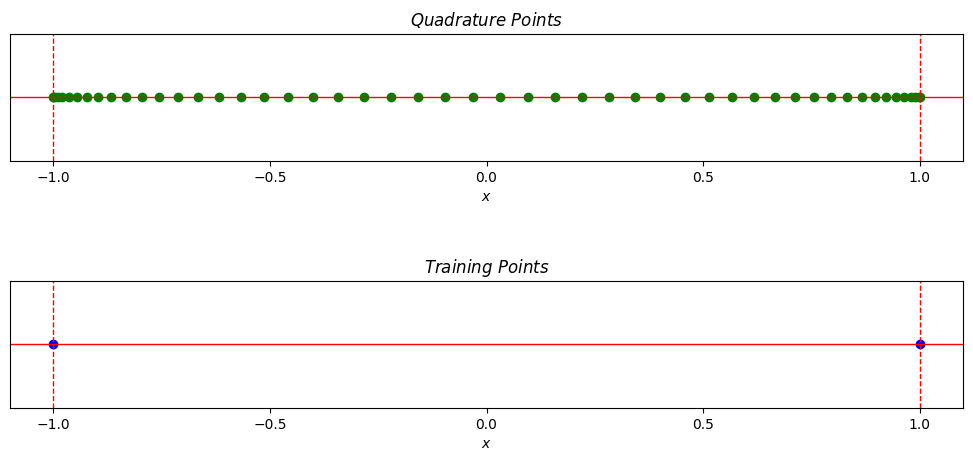

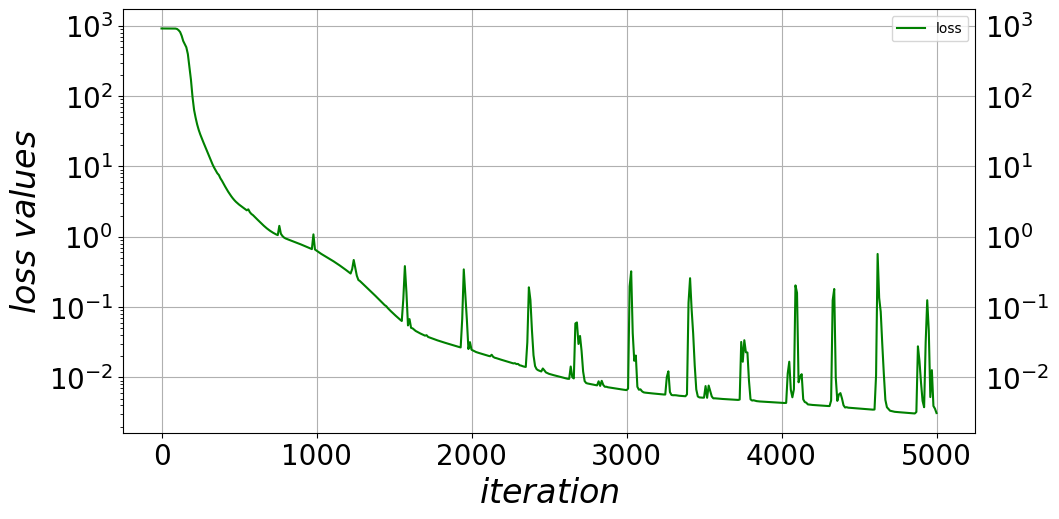

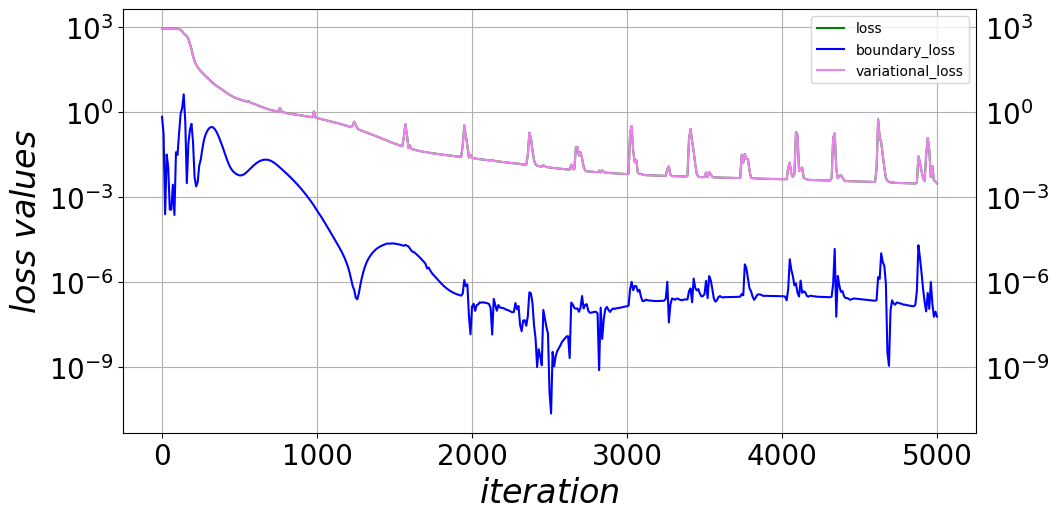

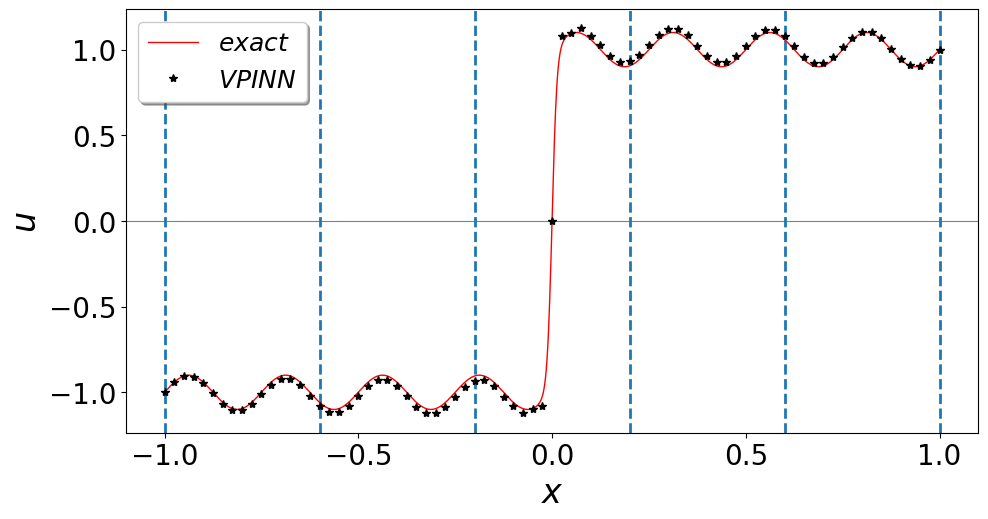

/tmp/ipykernel_19892/92857947.py:238: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.axvline(x=xc, linewidth=2, ls = '--')


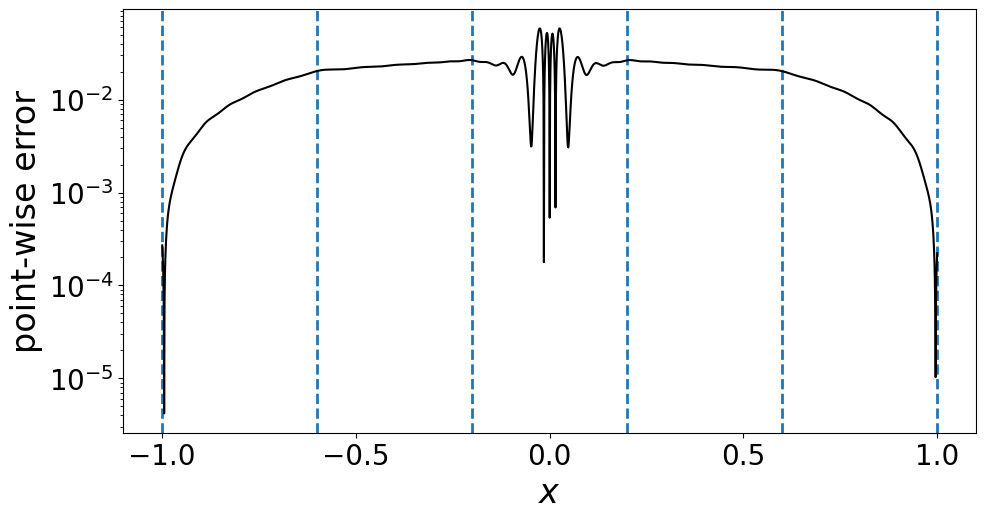

It: 0, Lossb: 6.151e-01, Lossv: 8.660e+02, Time: 1.34
It: 100, Lossb: 8.292e-03, Lossv: 8.635e+02, Time: 0.14
It: 200, Lossb: 1.234e-02, Lossv: 3.087e+01, Time: 0.18
It: 300, Lossb: 1.410e-02, Lossv: 7.970e+00, Time: 0.21
It: 400, Lossb: 3.389e-02, Lossv: 4.779e+00, Time: 0.19
It: 500, Lossb: 4.290e-02, Lossv: 2.632e+00, Time: 0.20
It: 600, Lossb: 5.523e-02, Lossv: 9.704e-01, Time: 0.18
It: 700, Lossb: 1.810e-02, Lossv: 2.471e-01, Time: 0.18
It: 800, Lossb: 3.591e-03, Lossv: 1.260e-01, Time: 0.18
It: 900, Lossb: 7.667e-04, Lossv: 6.663e-02, Time: 0.19
It: 1000, Lossb: 1.931e-04, Lossv: 4.287e-02, Time: 0.18
It: 1100, Lossb: 7.044e-05, Lossv: 6.093e-02, Time: 0.19
It: 1200, Lossb: 3.551e-05, Lossv: 2.411e-02, Time: 0.20
It: 1300, Lossb: 2.139e-05, Lossv: 2.053e-02, Time: 0.20
It: 1400, Lossb: 1.331e-05, Lossv: 1.884e-02, Time: 0.18
It: 1500, Lossb: 8.856e-06, Lossv: 1.676e-02, Time: 0.19
It: 1600, Lossb: 6.444e-06, Lossv: 1.559e-02, Time: 0.20
It: 1700, Lossb: 5.250e-06, Lossv: 1.465e-0

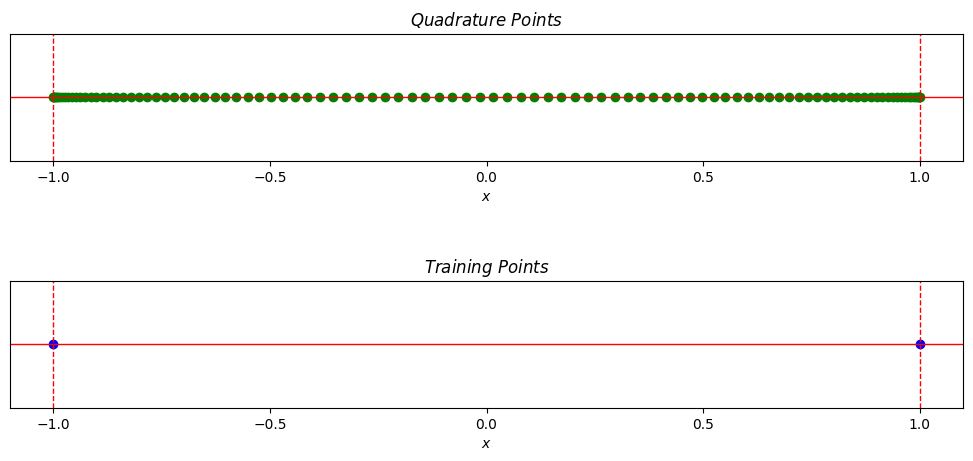

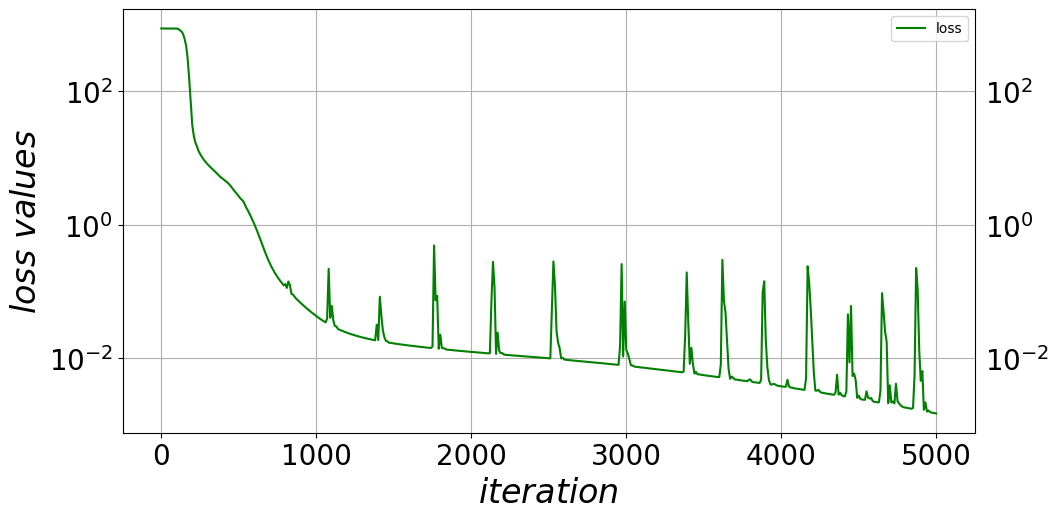

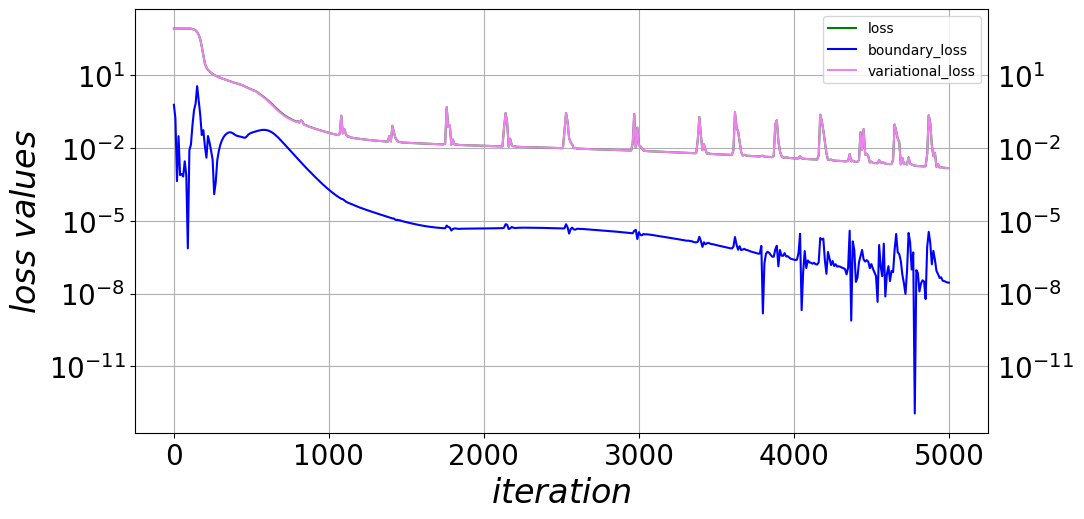

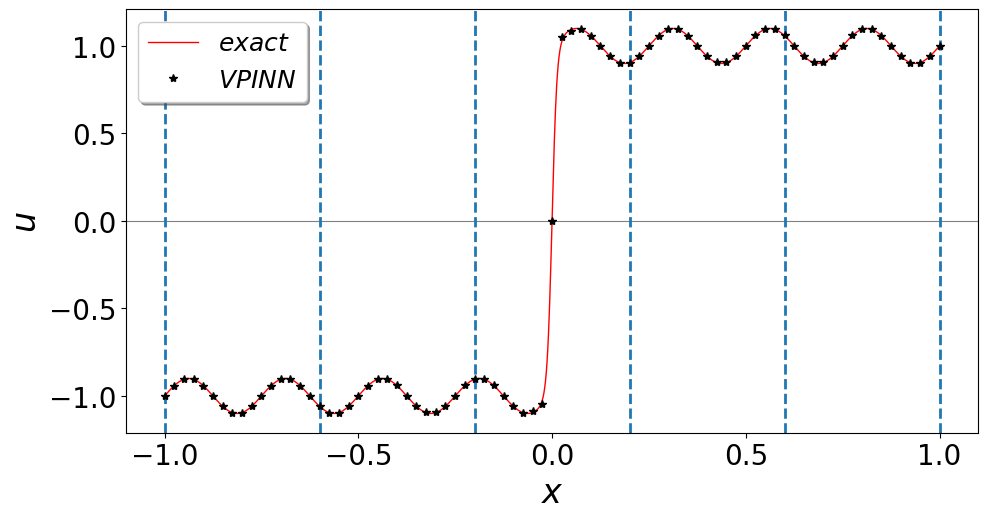

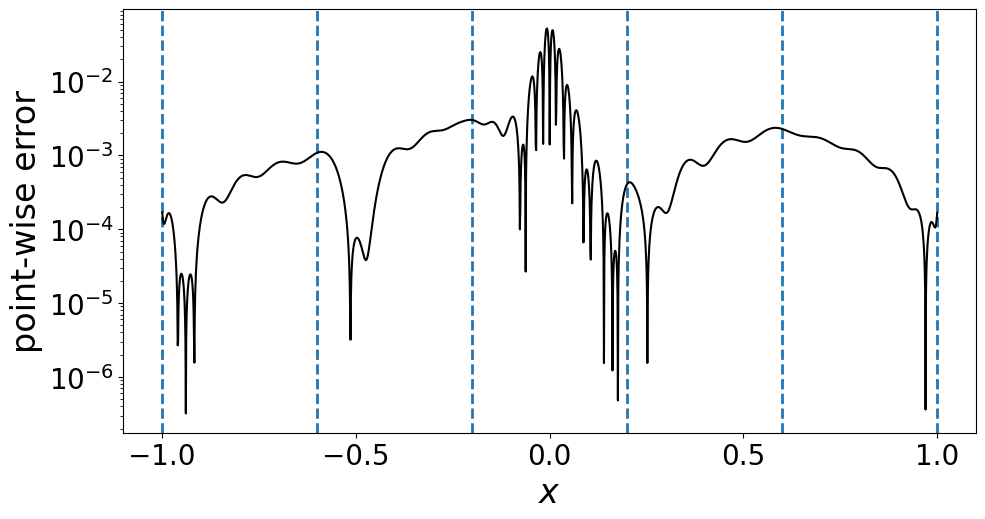

It: 0, Lossb: 8.339e-01, Lossv: 8.660e+02, Time: 1.69
It: 100, Lossb: 1.123e-04, Lossv: 8.660e+02, Time: 0.22
It: 200, Lossb: 2.738e-01, Lossv: 4.147e+02, Time: 0.25
It: 300, Lossb: 6.092e-02, Lossv: 9.899e+00, Time: 0.24
It: 400, Lossb: 8.376e-02, Lossv: 6.413e+00, Time: 0.24
It: 500, Lossb: 7.056e-02, Lossv: 4.975e+00, Time: 0.25
It: 600, Lossb: 2.423e-02, Lossv: 3.275e+00, Time: 0.25
It: 700, Lossb: 6.115e-03, Lossv: 2.465e+00, Time: 0.24
It: 800, Lossb: 5.464e-03, Lossv: 2.069e+00, Time: 0.24
It: 900, Lossb: 4.949e-03, Lossv: 2.255e+00, Time: 0.24
It: 1000, Lossb: 4.335e-03, Lossv: 1.608e+00, Time: 0.24
It: 1100, Lossb: 3.477e-03, Lossv: 1.426e+00, Time: 0.26
It: 1200, Lossb: 2.772e-03, Lossv: 1.225e+00, Time: 0.26
It: 1300, Lossb: 2.584e-03, Lossv: 9.517e-01, Time: 0.24
It: 1400, Lossb: 1.773e-03, Lossv: 5.720e-01, Time: 0.26
It: 1500, Lossb: 2.818e-04, Lossv: 3.184e-01, Time: 0.26
It: 1600, Lossb: 1.278e-04, Lossv: 2.314e-01, Time: 0.26
It: 1700, Lossb: 1.296e-04, Lossv: 1.936e-0

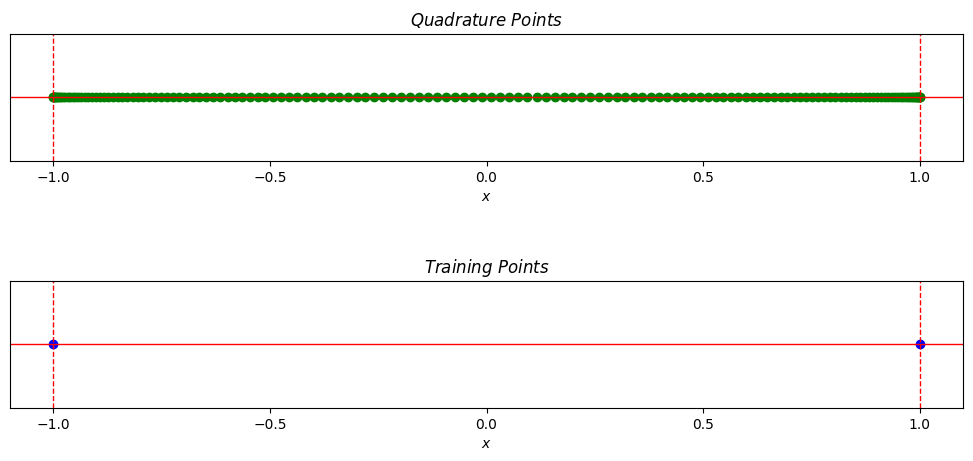

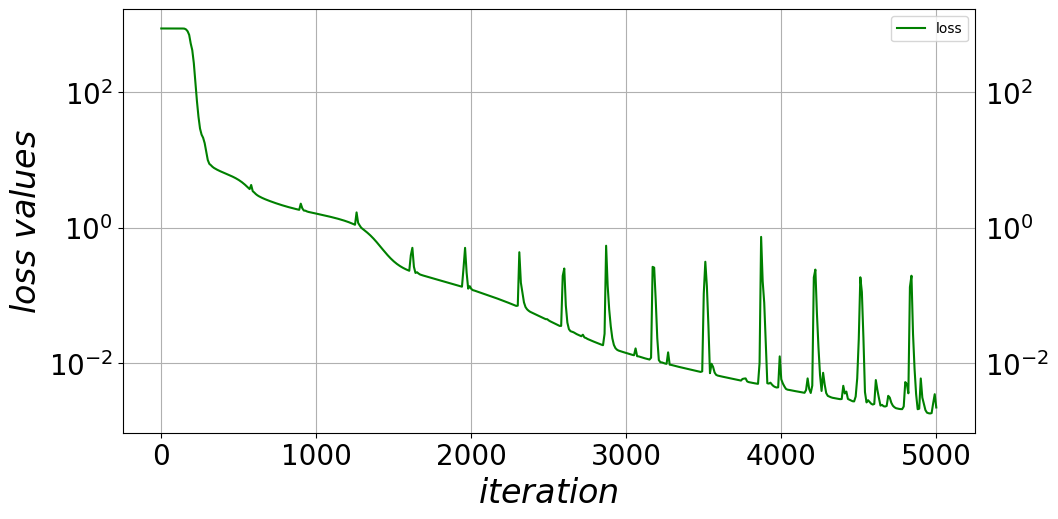

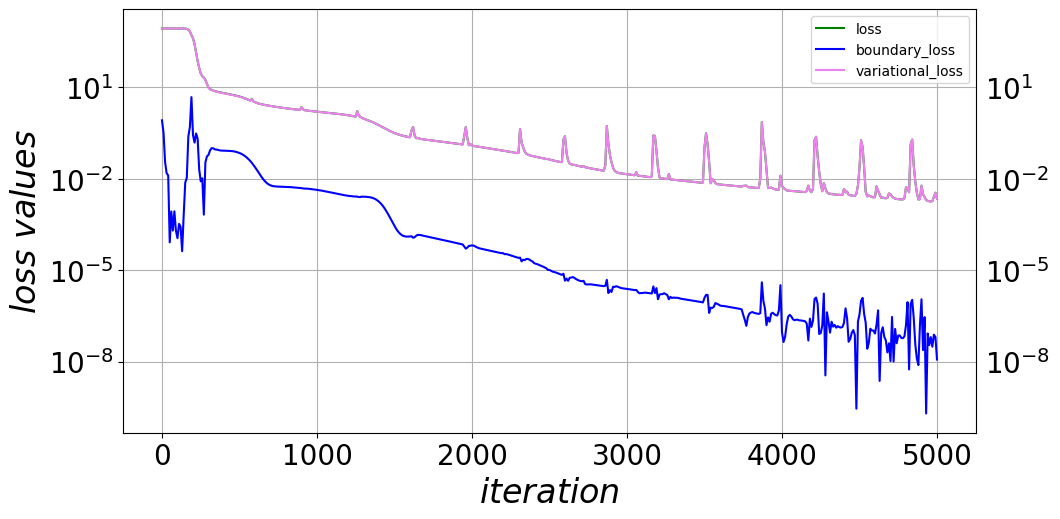

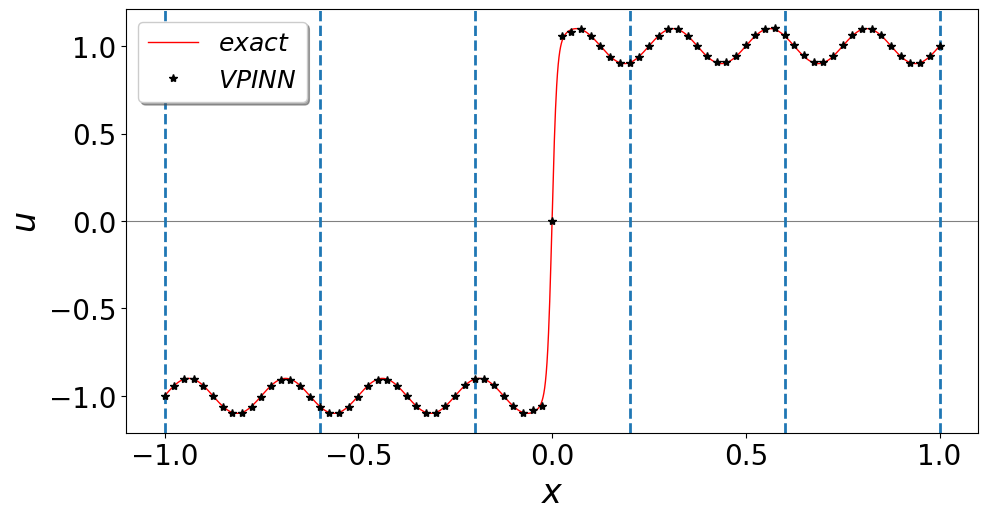

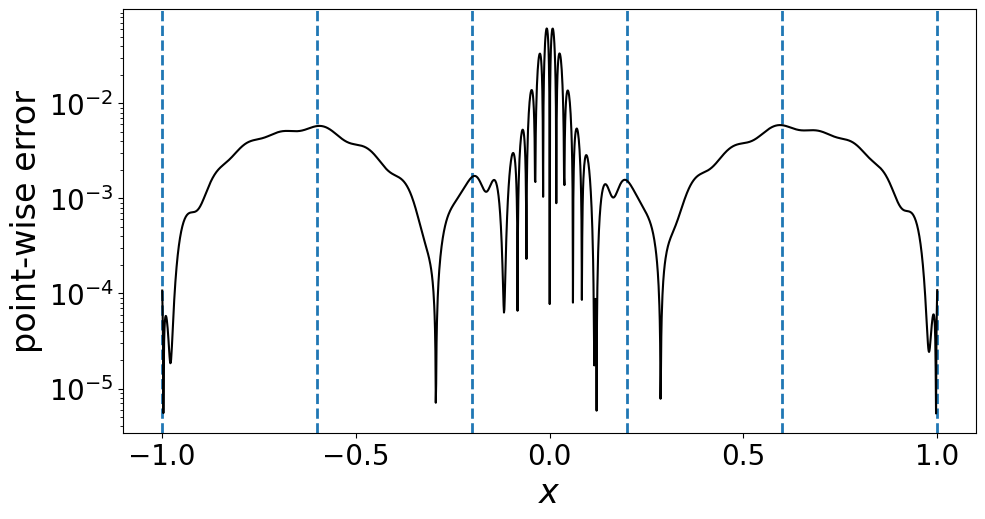

/home/mariano/Documenti/test/base/lib/python3.9/site-packages/scipy/special/_orthogonal.py:374: RuntimeWarning: invalid value encountered in scalar divide
  hn *= _gam(n + beta + 1.0) / _gam(n + 1) / _gam(n + ab1)
/home/mariano/Documenti/test/base/lib/python3.9/site-packages/scipy/special/_orthogonal.py:375: RuntimeWarning: invalid value encountered in scalar divide
  kn = _gam(2 * n + ab1) / 2.0**n / _gam(n + 1) / _gam(n + ab1)


It: 0, Lossb: 1.099e+00, Lossv: 8.660e+02, Time: 2.02
It: 100, Lossb: 8.931e-04, Lossv: 8.659e+02, Time: 0.26
It: 200, Lossb: 2.445e-01, Lossv: 9.545e+01, Time: 0.29
It: 300, Lossb: 2.585e-01, Lossv: 6.717e+00, Time: 0.29
It: 400, Lossb: 1.082e-01, Lossv: 3.371e+00, Time: 0.28
It: 500, Lossb: 5.576e-02, Lossv: 1.960e+00, Time: 0.29
It: 600, Lossb: 1.970e-02, Lossv: 1.313e+00, Time: 0.29
It: 700, Lossb: 3.100e-03, Lossv: 8.768e-01, Time: 0.29
It: 800, Lossb: 3.117e-05, Lossv: 5.595e-01, Time: 0.29
It: 900, Lossb: 1.181e-03, Lossv: 3.753e-01, Time: 0.30
It: 1000, Lossb: 1.577e-03, Lossv: 2.911e-01, Time: 0.29
It: 1100, Lossb: 1.158e-03, Lossv: 2.466e-01, Time: 0.33
It: 1200, Lossb: 6.452e-04, Lossv: 2.124e-01, Time: 0.30
It: 1300, Lossb: 3.064e-04, Lossv: 3.718e-01, Time: 0.30
It: 1400, Lossb: 1.236e-04, Lossv: 1.667e-01, Time: 0.30
It: 1500, Lossb: 4.956e-05, Lossv: 1.497e-01, Time: 0.30
It: 1600, Lossb: 2.787e-05, Lossv: 1.711e-01, Time: 0.30
It: 1700, Lossb: 8.552e-06, Lossv: 1.223e-0

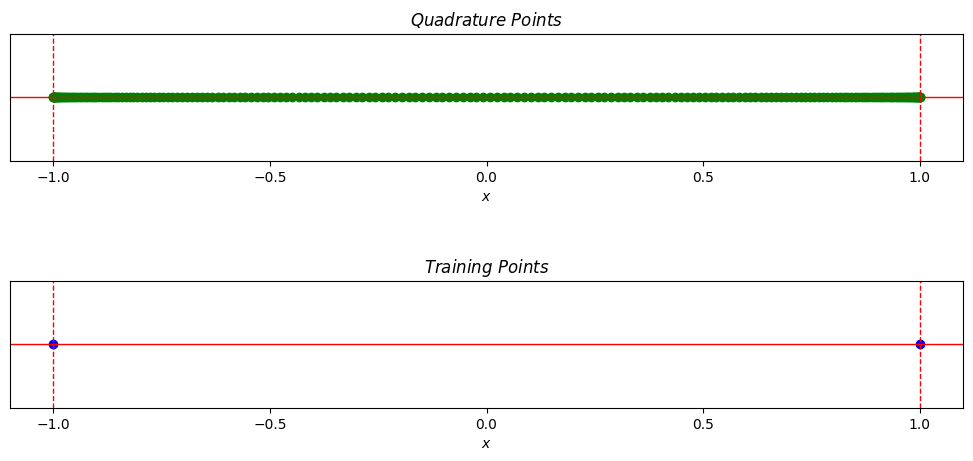

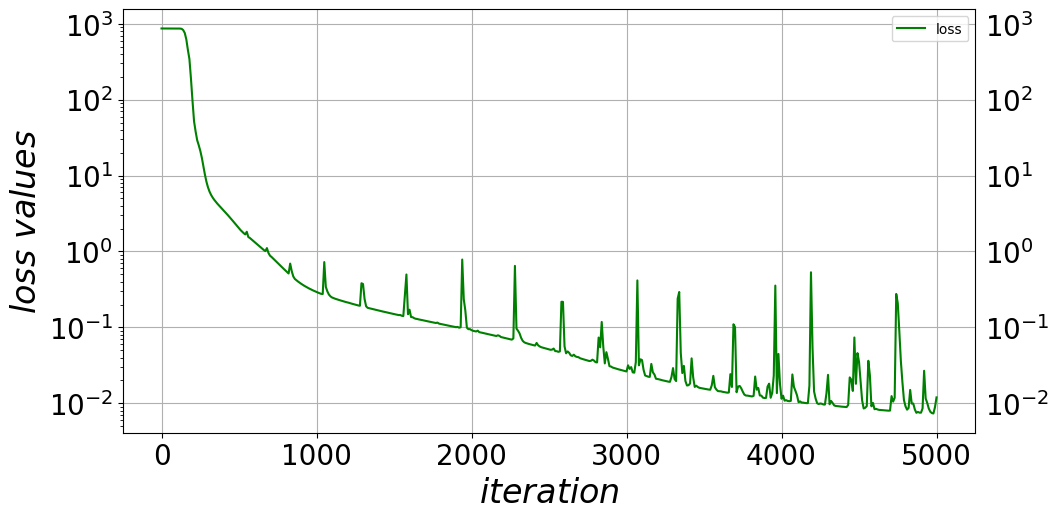

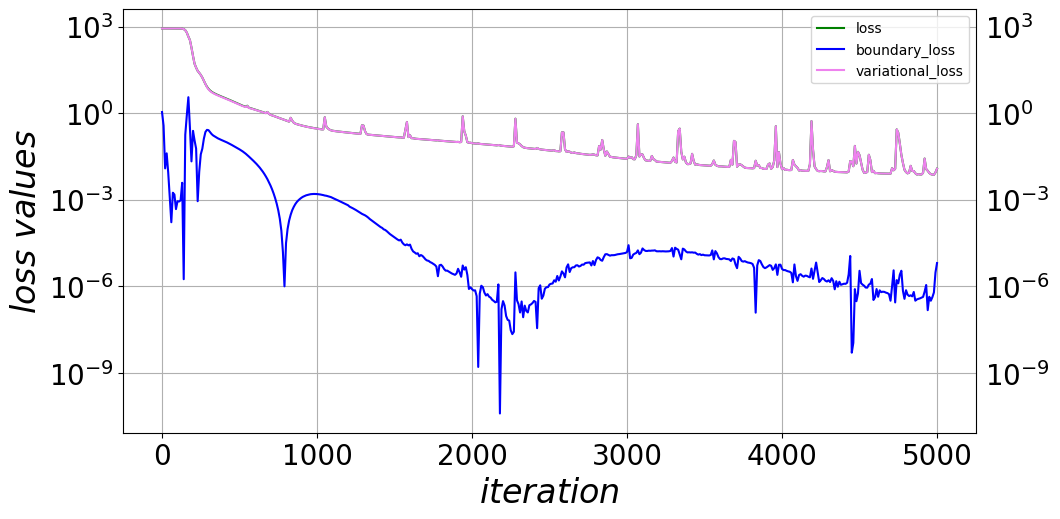

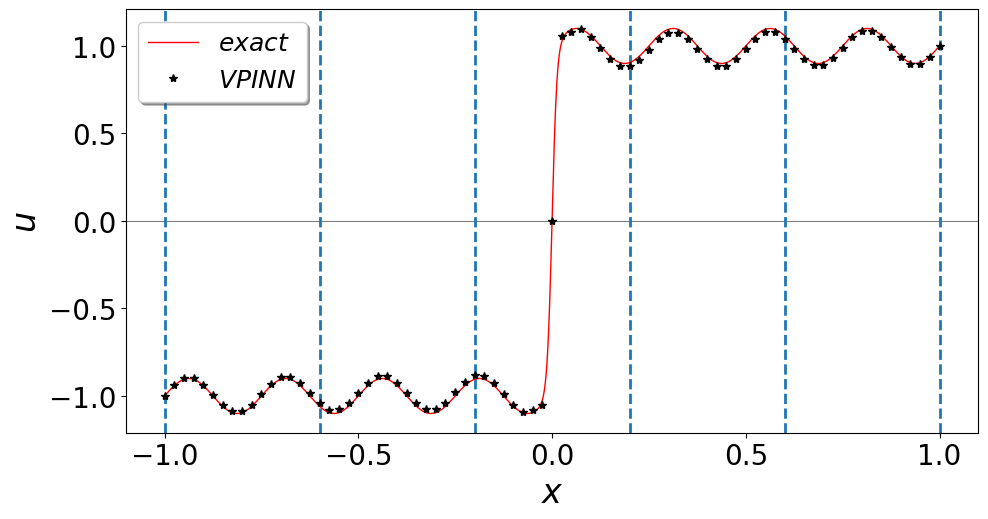

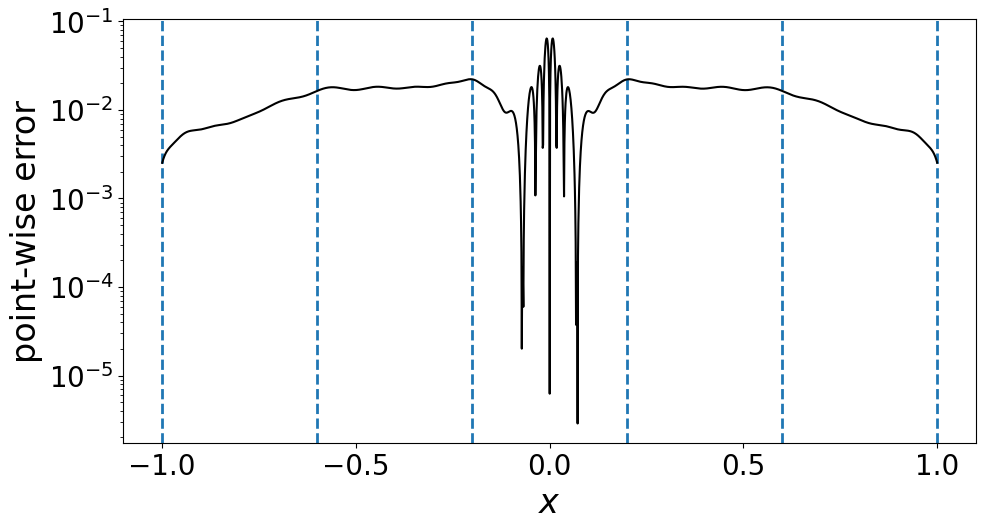

It: 0, Lossb: 1.674e+00, Lossv: 8.660e+02, Time: 2.25
It: 100, Lossb: 1.252e-04, Lossv: 8.660e+02, Time: 0.35
It: 200, Lossb: 8.011e-01, Lossv: 5.196e+02, Time: 0.41
It: 300, Lossb: 9.748e-02, Lossv: 2.093e+01, Time: 0.42
It: 400, Lossb: 7.516e-02, Lossv: 4.740e+00, Time: 0.42
It: 500, Lossb: 4.352e-03, Lossv: 3.046e+00, Time: 0.42
It: 600, Lossb: 8.063e-04, Lossv: 2.342e+00, Time: 0.41
It: 700, Lossb: 4.827e-04, Lossv: 1.613e+00, Time: 0.42
It: 800, Lossb: 4.518e-07, Lossv: 1.042e+00, Time: 0.42
It: 900, Lossb: 1.453e-04, Lossv: 6.922e-01, Time: 0.44
It: 1000, Lossb: 4.180e-05, Lossv: 4.546e-01, Time: 0.44
It: 1100, Lossb: 8.305e-05, Lossv: 3.000e-01, Time: 0.42
It: 1200, Lossb: 2.153e-04, Lossv: 1.893e-01, Time: 0.43
It: 1300, Lossb: 5.202e-05, Lossv: 1.407e-01, Time: 0.43
It: 1400, Lossb: 1.163e-05, Lossv: 1.208e-01, Time: 0.46
It: 1500, Lossb: 3.426e-06, Lossv: 1.059e-01, Time: 0.46
It: 1600, Lossb: 1.174e-06, Lossv: 9.424e-02, Time: 0.45
It: 1700, Lossb: 6.742e-07, Lossv: 8.512e-0

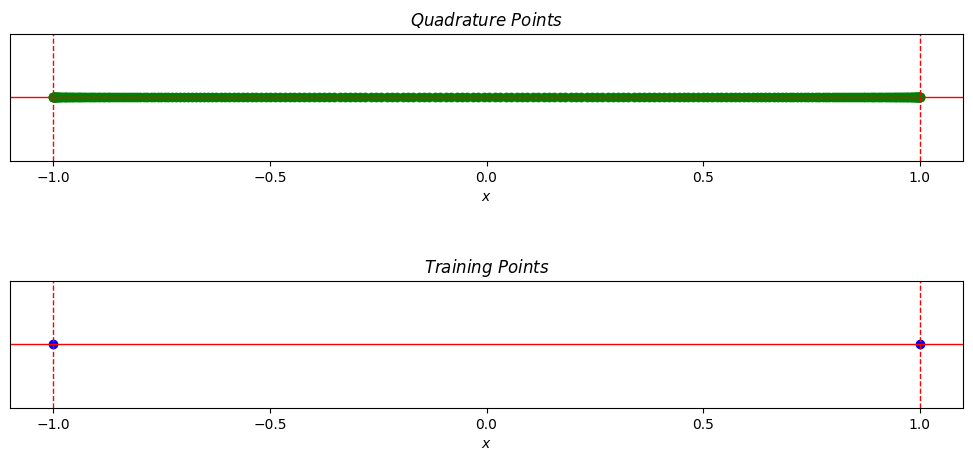

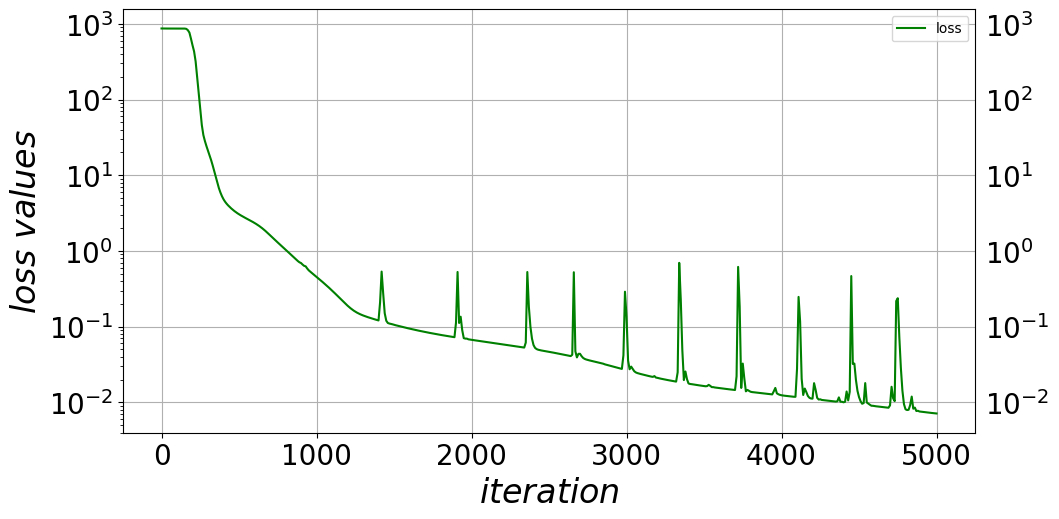

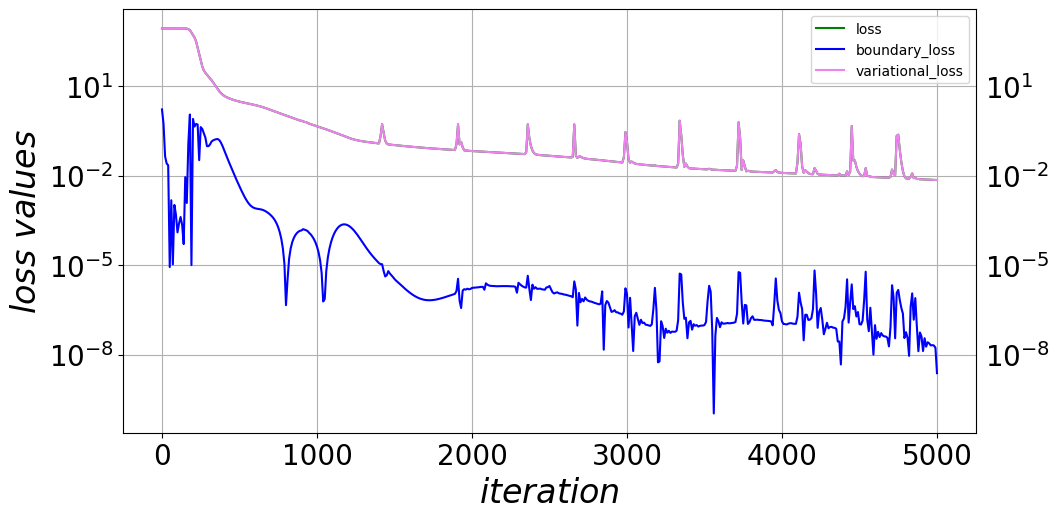

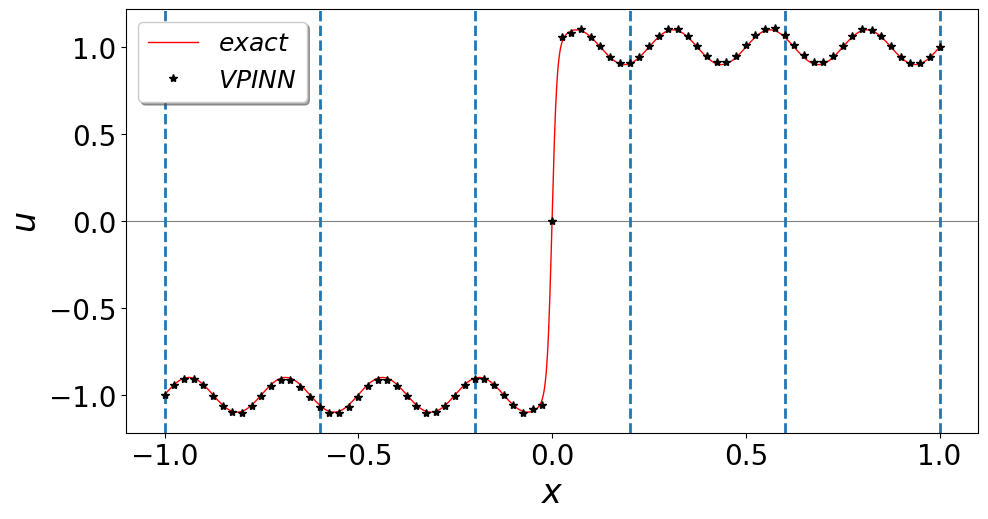

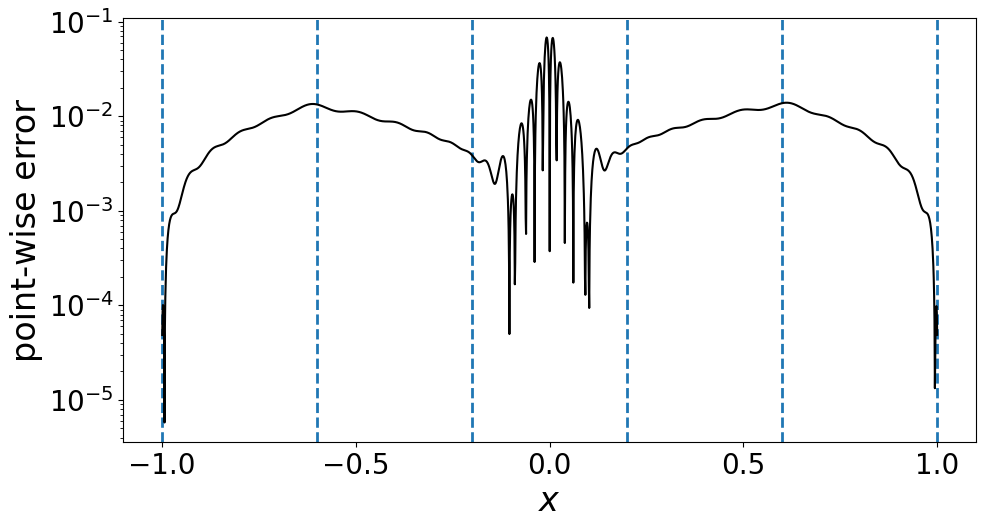

In [16]:
quad=[50,100 ,150 ,200, 250]
for iter in range(len(quad)):

# from tensorflow import placeholder

                    # a(u,v)=f(v) u in H1 such that is 0 on diriclet boundary for every v in V -->ah(u,vh)=fh(vh) for every vh in Vh

    
    #++++++++++++++++++++++++++++
    LR = 0.001
    Opt_Niter = 5000 + 1
    Opt_tresh = 2e-32
    var_form  = 2  #i think that makes the most sense leaving it to 2(variational form)
    N_Element = 5
    Net_layer = [1] + [20] * 4 + [1] # [1 20 20 20 20 1] number of neurons in each later numer of param == (input_layer+1)*output_layer in this case 2*20+3*(21*20)+21*1=1321 total param
    N_testfcn = 20 #number of test function
    N_Quad = quad[iter]    #quadrature points 
    N_F = 500      #number of points used for trianing 
    lossb_weight = 1 #hyprparameter we may turn it up

    params = {'var_form': var_form, 'lossb_weight': lossb_weight, 'LR': LR}
        
    #++++++++++++++++++++++++++++    valuete Test function of order n in a point x(n>=1)
    def Test_fcn(n,x):
        test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
        return test

    #++++++++++++++++++++++++++++    
    #exact sol and forcing term
    omega = 8*np.pi
    amp = 1
    r1 = 80
    def u_ext(x):
        utemp = 0.1*np.sin(omega*x) + np.tanh(r1*x)
        return amp*utemp

    def f_ext(x):
        gtemp =  -0.1*(omega**2)*np.sin(omega*x) - (2*r1**2)*(np.tanh(r1*x))/((np.cosh(r1*x))**2)
        return -amp*gtemp

    #++++++++++++++++++++++++++++ generate once for all quad nodes and weights in the interval [-1,1]
    NQ_u = N_Quad
    [x_quad, w_quad] = GaussLobattoJacobiWeights(NQ_u, 0, 0)
    testfcn = np.asarray([ Test_fcn(n,x_quad)  for n in range(1, N_testfcn+1)])

    #generate grid elements,for each element the number of test fuction is the same  
    NE = N_Element
    [x_l, x_r] = [-1, 1]
    delta_x = (x_r - x_l)/NE
    grid = np.asarray([ x_l + i*delta_x for i in range(NE+1)])
    N_testfcn_total = np.array((len(grid)-1)*[N_testfcn])

    if N_Element == 3:
        grid = np.array([-1, -0.1, 0.1, 1])
        NE = len(grid)-1
        N_testfcn_total = np.array([N_testfcn,N_testfcn,N_testfcn])

    U_ext_total = []
    F_ext_total = []
    for e in range(NE):
        x_quad_element = grid[e] + (grid[e+1]-grid[e])/2*(x_quad+1)
        jacobian = (grid[e+1]-grid[e])/2
        N_testfcn_temp = N_testfcn_total[e]
        testfcn_element = np.asarray([ Test_fcn(n,x_quad)  for n in range(1, N_testfcn_temp+1)])
        
        #is this my left side ot the variational form ah calculated in the real nodal values ?  
        u_quad_element = u_ext(x_quad_element)
        U_ext_element  = jacobian*np.asarray([sum(w_quad*u_quad_element*testfcn_element[i]) for i in range(N_testfcn_temp)])
        U_ext_element = U_ext_element[:,None]
        U_ext_total.append(U_ext_element)
        #this is fh calculated on the real nodal values summed over each real nodal values(which comes form CGL nodes )
        f_quad_element = f_ext(x_quad_element)
        F_ext_element  = jacobian*np.asarray([sum(w_quad*f_quad_element*testfcn_element[i]) for i in range(N_testfcn_temp)])
        F_ext_element = F_ext_element[:,None]
        F_ext_total.append(F_ext_element)

    # at the end i have an array with my all my "real" residues
    U_ext_total = np.asarray(U_ext_total)
    F_ext_total = np.asarray(F_ext_total)

    #++++++++++++++++++++++++++++
    # Training points
    X_u_train = np.asarray([-1.0,1.0])[:,None]
    u_train   = u_ext(X_u_train)
    X_bound = np.asarray([-1.0,1.0])[:,None]

    Nf = N_F
    X_f_train = (2*lhs(1,Nf)-1) #generate random number of training points 
    f_train   = f_ext(X_f_train) #evaluete these points on f(forcing therm)

    #++++++++++++++++++++++++++++
    # Quadrature points
    [x_quad, w_quad] = GaussLobattoJacobiWeights(N_Quad, 0, 0)

    X_quad_train = x_quad[:,None] #[[w1],[w2]] none stands for new axis
    W_quad_train = w_quad[:,None]

    #++++++++++++++++++++++++++++
    # Test point
    delta_test = 0.001
    xtest      = np.arange(-1 , 1 + delta_test , delta_test)  #linspace
    data_temp  = np.asarray([ [xtest[i],u_ext(xtest[i])] for i in range(len(xtest))]) # pair input real ouput 
    X_test = data_temp.flatten()[0::2]
    u_test = data_temp.flatten()[1::2]
    #test values 
    X_test = X_test[:,None] 
    u_test = u_test[:,None] 
    f_test = f_ext(X_test)

    u_test_total = []
    for e in range(NE):
        x_test_element = grid[e] + (grid[e+1]-grid[e])/2*(xtest+1)
        u_test_element = u_ext(x_test_element)
        u_test_element = u_test_element[:,None]
        u_test_total.append(u_test_element)

    model = VPINN(X_u_train, u_train, X_quad_train, W_quad_train, F_ext_total,\
                grid, X_test, u_test, Net_layer, X_f_train, f_train, params=params)


    total_record = model.train(Opt_Niter, Opt_tresh, [])
    u_pred = model.predict(X_test)
    x_quad_plot = X_quad_train

    print("RUN with quad points: ",quad[iter])
    y_quad_plot = np.empty(len(x_quad_plot))
    y_quad_plot.fill(1)

    x_train_plot = X_u_train
    y_train_plot = np.empty(len(x_train_plot))
    y_train_plot.fill(1) 

    x_f_plot = X_f_train
    y_f_plot = np.empty(len(x_f_plot))
    y_f_plot.fill(1)







    fig = plt.figure(0)
    gridspec.GridSpec(3,1)

    plt.subplot2grid((3,1), (0,0))
    plt.tight_layout()
    plt.locator_params(axis='x', nbins=6)
    plt.yticks([])
    plt.title('$Quadrature \,\, Points$')
    plt.xlabel('$x$')
    plt.axhline(1, linewidth=1, linestyle='-', color='red')
    plt.axvline(-1, linewidth=1, linestyle='--', color='red')
    plt.axvline(1, linewidth=1, linestyle='--', color='red')
    plt.scatter(x_quad_plot,y_quad_plot, color='green')

    plt.subplot2grid((3,1), (1,0))
    plt.tight_layout()
    plt.locator_params(axis='x', nbins=6)
    plt.yticks([])
    plt.title('$Training \,\, Points$')
    plt.xlabel('$x$')
    plt.axhline(1, linewidth=1, linestyle='-', color='red')
    plt.axvline(-1, linewidth=1, linestyle='--', color='red')
    plt.axvline(1, linewidth=1, linestyle='--', color='red')
    #the data points are only the boundary points!!!!
    plt.scatter(x_train_plot,y_train_plot, color='blue')

    fig.tight_layout()
    fig.set_size_inches(w=10,h=7)
    plt.show()
    # plt.savefig('Train-Quad-pnts.pdf')    
    #++++++++++++++++++++++++++++

    font = 24
    #all loss
    fig, ax = plt.subplots()
    plt.tick_params(axis='y', which='both', labelleft='on', labelright='off') 
    plt.xlabel('$iteration$', fontsize = font)
    plt.ylabel('$loss \,\, values$', fontsize = font)
    plt.yscale('log')
    plt.grid(True)
    iteration = [total_record[i][0] for i in range(len(total_record))]
    loss_his  = [total_record[i][1] for i in range(len(total_record))]
    plt.plot(iteration, loss_his,'green',label="loss")
    plt.legend(loc="upper right")
    plt.tick_params( labelsize = 20)
    fig.set_size_inches(w=11,h=5.5)
    plt.show()
    # plt.savefig('loss.pdf')
    #++++++++++++++++++++++++++++
    #partial loss
    fig, ax = plt.subplots()
    plt.tick_params(axis='y', which='both', labelleft='on', labelright='off')
    plt.xlabel('$iteration$', fontsize = font)
    plt.ylabel('$loss \,\, values$', fontsize = font)
    plt.yscale('log')
    plt.grid(True)
    iteration = [total_record[i][0] for i in range(len(total_record))]
    loss_his  = [total_record[i][1] for i in range(len(total_record))]
    loss_b  = [total_record[i][2] for i in range(len(total_record))]
    loss_v  = [total_record[i][3] for i in range(len(total_record))]
    plt.plot(iteration, loss_his,'green',label="loss")
    plt.plot(iteration, loss_b,'blue',label="boundary_loss")
    plt.plot(iteration, loss_v, 'violet',label="variational_loss")
    plt.legend(loc="upper right")
    plt.tick_params( labelsize = 20)
    fig.set_size_inches(w=11,h=5.5)
    plt.show()


    pnt_skip = 25
    fig, ax = plt.subplots()
    plt.locator_params(axis='x', nbins=6)
    plt.locator_params(axis='y', nbins=8)
    plt.xlabel('$x$', fontsize = font)
    plt.ylabel('$u$', fontsize = font)
    plt.axhline(0, linewidth=0.8, linestyle='-', color='gray')
    for xc in grid:
        plt.axvline(x=xc, linewidth=2, ls = '--')
    plt.plot(X_test, u_test, linewidth=1, color='r', label=''.join(['$exact$']))
    plt.plot(X_test[0::pnt_skip], u_pred[0::pnt_skip], 'k*', label='$VPINN$')
    plt.tick_params( labelsize = 20)
    legend = plt.legend(shadow=True, loc='upper left', fontsize=18, ncol = 1)
    fig.set_size_inches(w=11,h=5.5)
    plt.show()
    # plt.savefig('prediction.pdf')
    #++++++++++++++++++++++++++++

    fig, ax = plt.subplots()
    plt.locator_params(axis='x', nbins=6)
    plt.locator_params(axis='y', nbins=8)
    plt.xlabel('$x$', fontsize = font)
    plt.ylabel('point-wise error', fontsize = font)
    plt.yscale('log')
    plt.axhline(0, linewidth=0.8, linestyle='-', color='gray')
    for xc in grid:
        plt.axvline(x=xc, linewidth=2, ls = '--')
    plt.plot(X_test, abs(u_test - u_pred), 'k')
    plt.tick_params( labelsize = 20)
    fig.set_size_inches(w=11,h=5.5)
    plt.show()
